# Assignment 4 – Machine Learning Fashionista
`SVC` | `PCA` | `LDA` 

### 1. Problem Definition

The aim of this project is to observe/estimate the impact of modeling with reduced image representations on the performance of a classifier (Linear Suppor Vector Classifier (SVC)) for `jerseys` and `shirts`. Specifically, I look into reduced image representations obtained through Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA), and compare these to the model's performance on the original image pixel data. As an extension, I also explore the classifier's performance on a reduced representation obtained from a joint dimension reduction using PCA and then LDA.


Here, the classification problem can really be defined as distinguishing between `jersey` and `non-jersey` shirts. Hence, in the `shirts` dataset, we have a variety from the broader class of shirts such as T-shirts, blouses, etc., but no `jerseys` – this is ensured in the cleaning phase discussed below. The `jersey` dataset, on the otherhand, contains to a high degree of confidence, only jerseys. Here a jersey is taken to mean shirts worn specifically for sporting activities such as football or basketball.

### 2. Data Extraction & Cleaning Discussion
The original datasets were obtained from ImageNet as per the assignment prompt. However, the datasets were very messy and had significant overlap (e.g. multiple jerseys in the `shirts` dataset and multiple corporate shirts in the `jersey` data). As these would pose significant difficulty for a future classifier to model on, I manually scanned through both datasets and performed the following operations:

- Moving images to their correct datasets (e.g. moving images of jerseys from `shirts` to `jerseys`)
- Deleting images that contained both shirts and jerseys, etc. - it would be hard to assign a class to these
- Deleting images that had nothing to do with the relevant classes (jerseys or shirts)

Following this procedure, the `jersey` dataset was left very sparse. Hence, I extracted more jersey images from Google images using a Google Chrome extension called [`Image downloader - Imageye`](https://chrome.google.com/webstore/detail/image-downloader-imageye/agionbommeaifngbhincahgmoflcikhm). To do so, queries along the lines of `jersey football` or `jersey basketball` were searched for. The resulting `jerseys` dataset following this extraction procedure had about 250 images.

Now our datasets are ready for modeling!

### 3. Library Importation

In [1]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt

### 4. Loading & preprocessing the images
Load the first 250 images in both datasets and resize to 400 by 400 px

In [2]:
#Note the two different classes (these are names of the directories containing them)
clothing_classes = ['jerseys','shirts']

#List to store all the flattened images – for all classes
flattened_imgs = []

#Size to resize images to
img_size = [400,400]

#Iterate through both classes
for clothing_class in enumerate(clothing_classes):
    
    #Create path for the image class of interest
    class_imgs = glob(f'{clothing_class[1]}/*.JPEG')
    
    #For each image path
    for path in class_imgs[:250]:
        
        #Open it as a read file in binary mode
        with open(path, 'r+b') as f:
            
            #Open it as an image
            with Image.open(f) as image:
                
                #Check if the image is too small
                if min(image.size) < min(img_size):
                    
                    #If it is, enlarge to the img_size
                    cover = image.resize(img_size)
                    
                else:
                    #Resize the image to be more manageable
                    cover = resizeimage.resize_cover(image, img_size)
                    
                #Flatten the matrix to an array and append it to all flattened images list
                flattened_imgs.append((np.array(cover).flatten(),clothing_class[0]))
         
#Flatten once more
flattened_imgs = np.asarray(flattened_imgs)

#Make a copy of the array to shuffle
flattened_and_shuffled = flattened_imgs.copy()

#Shuffle the array containing all the images and their labels – this will be helpful when splitting to training and test set
np.random.default_rng().shuffle(flattened_and_shuffled)
    
#Split into images and labels and reshape X thus: (number of images, 3*number of pixels)
X = np.stack(i for i in flattened_and_shuffled[:,0])
Y = np.stack(i for i in flattened_and_shuffled[:,1])

/Users/koredeakande/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/Users/koredeakande/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [25]:
#Check shape of images
X.shape

(500, 480000)

### 5. Data Exploration
`Visualizing some of the images`

**Jerseys**

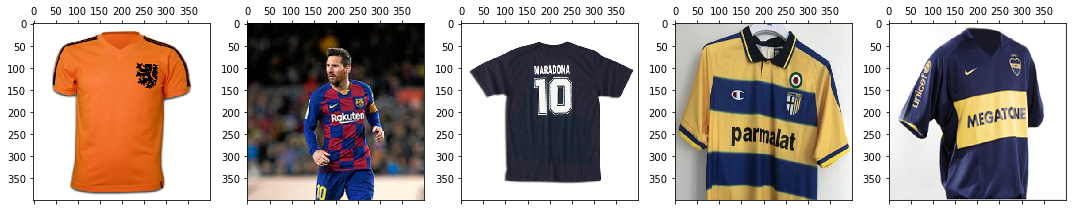

In [3]:
plt.figure(figsize=(15,15))
for idx,img in enumerate(np.random.choice(250,5)):
    plt.subplot(1,5,idx+1).matshow(flattened_imgs[img,0].reshape((400,400,3)))
plt.tight_layout()
plt.show()

**Shirts (i.e. Non-jerseys)**

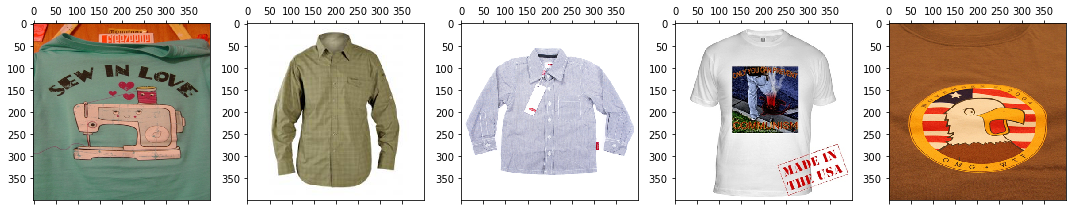

In [5]:
plt.figure(figsize=(15,15))
for idx,img in enumerate(np.random.choice(range(251,len(X)),5)):
    plt.subplot(1,5,idx+1).matshow(flattened_imgs[img,0].reshape((400,400,3)))

plt.tight_layout()
plt.show()

### 6. Splitting the data into train and test
Split dataset into 80% training data and 20% testing data for modeling

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20)

In [12]:
#Check class proportion after split – to ensure roughly equal
np.unique(y_train, return_counts=True)

(array([0, 1]), array([202, 198]))

### 7. Modeling: Linear SVC
Building a simple linear classifier (here SVC) using the original pixel data

In [14]:
#Perform a grid search to determine the optimal C value for linear SVC
clf = GridSearchCV(estimator = SVC(kernel='linear'),
                   param_grid = {'C': [0.1, 1, 10]}, 
                   cv=2, verbose = 2)

#Fit on the training data which are in original pixel form
clf.fit(X_train,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................................ C=0.1, total=  52.8s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.9s remaining:    0.0s


[CV] ............................................ C=0.1, total=  44.8s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total= 1.2min
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=  56.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  57.8s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=  48.6s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.5min finished


GridSearchCV(cv=2, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10]}, verbose=2)

In [16]:
#Display the parameters for the best estimator from grid search
clf.best_estimator_

SVC(C=0.1, kernel='linear')

#### a. Computing error rate

**Training set**

In [17]:
#Compute error rate for training data with best estimator
train_acc_score = clf.best_estimator_.score(X_train,y_train)
train_error = 1 - train_acc_score
print(f"Training set error rate: {train_error}")

Training set error rate: 0.0


**Test set**

In [18]:
#Compute error rate for test data
test_acc_score = clf.best_estimator_.score(X_test,y_test)
test_error = 1 - test_acc_score
print(f"Test set error rate: {test_error}")

Test set error rate: 0.29000000000000004


We see evidence of overfitting in the linear SVC model above – we get perfect accuracy (i.e. 0% error rate) on the training set, but have huge error (29%) when predicting on the test set. In short, the model picks up on intricacies/noise in the training data and thus does not generalize well to new data.

#### b. Confusion matrix
`Test set`

I also plot the confusion matrix to get more insight into where the model is struggling/underperforming

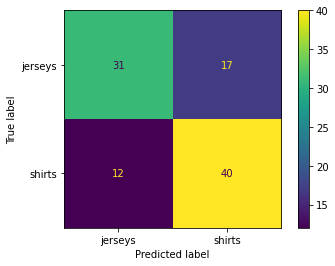

In [20]:
plot_confusion_matrix(clf.best_estimator_, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 

Predictive performance for shirts and jerseys are not vastly different, but the model appears to predict shirts slightly more accurately than it does jerseys. 

### 8. Modeling: PCA + Linear SVC
Training the same SVC linear model above, but now on a reduced representation created using PCA

In [21]:
#Note steps – these will be used in the creation of a pipeline
estimators = [('reduce_dim', PCA()), 
              ('clf', clf.best_estimator_)]

#Create pipeline
pipe = Pipeline(estimators)

#Create parameter list for optimization trial
#Here we trying to optimize the number of PCs to fit with
params = {'reduce_dim__n_components': [2, 5]}

#Run grid search to find best parameters given the training data
pca_svc_gs_cv = GridSearchCV(pipe, param_grid = params, cv=2, verbose=2)
pca_svc_gs_cv.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] reduce_dim__n_components=2 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... reduce_dim__n_components=2, total= 4.0min
[CV] reduce_dim__n_components=2 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s


[CV] ....................... reduce_dim__n_components=2, total= 5.1min
[CV] reduce_dim__n_components=5 ......................................
[CV] ....................... reduce_dim__n_components=5, total= 3.1min
[CV] reduce_dim__n_components=5 ......................................
[CV] ....................... reduce_dim__n_components=5, total= 4.4min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.5min finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('reduce_dim', PCA()),
                                       ('clf', SVC(C=0.1, kernel='linear'))]),
             param_grid={'reduce_dim__n_components': [2, 5]}, verbose=2)

#### a. Computing error rate

**Training set**

In [24]:
#Compute error rate for training data with best estimator
pca_svc_train_acc_score = pca_svc_gs_cv.best_estimator_.score(X_train,y_train)
pca_svc_train_error = 1 - pca_svc_train_acc_score
print(f"Training set error rate (PCA + SVC): {pca_svc_train_error}")

Training set error rate (PCA + SVC): 0.28500000000000003


**Test set**

In [25]:
#Compute error rate for training data with best estimator
pca_svc_test_acc_score = pca_svc_gs_cv.best_estimator_.score(X_test,y_test)
pca_svc_test_error = 1 - pca_svc_test_acc_score
print(f"Test set error rate (PCA + SVC): {pca_svc_test_error}")

Test set error rate (PCA + SVC): 0.31999999999999995


From the above results, we see that the training set error is very high indicating the presence of underfitting. The model even performs better on the test set than the training set.
Comparing to the previous (SVC only) model, this PCA + SVC model performs worse on both the training and test data

#### b. Confusion matrix
`Test set`

I also plot a confusion matrix to get more insight into where the model is struggling/underperforming

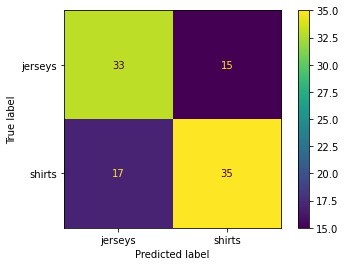

In [27]:
plot_confusion_matrix(pca_svc_gs_cv.best_estimator_, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 

Classifiers performance predicting jerseys and shirts is pretty much the same.

### 9. Modeling: LDA + Linear SVC
Training the same linear SVC model, but now on a reduced representation created using LDA

The below grid search (commented out) kept crashing the kernel. Hence, I do not perform a grid search for this section. I instead utilize the default sklearn LDA configuration (projects to num_classes -1 dimensions i.e. 1 dimension here) and the best SVC estimator based on the Grid Search from Section 6: SVC(C=0.1,kernel='linear'). Ideally, I would have also optimized the parameter C for the SVC model in the pipeline below as it is possible a different configuration would lead to better results (although, I wouldn't expect the difference to be drastic!)

#Note steps – these will be used in the creation of a pipeline
lda_svc_estimators = [('LDA', LinearDiscriminantAnalysis()), 
                      ('clf', clf.best_estimator_)]

#Create pipeline
lda_svc_pipe = Pipeline(lda_svc_estimators)

#Create parameter list for optimization trial
lda_svc_params = {'LDA__solver': ['svd', 'lsqr', 'eigen']}

#Run grid search to find best parameters given the training data
lda_svc_gs = GridSearchCV(lda_svc_pipe, 
                          param_grid = lda_svc_params, 
                          cv=2, verbose=2)

lda_svc_gs.fit(X_train, y_train)

In [13]:
#Note steps – these will be used in the creation of a pipeline
lda_svc_estimators = [('LDA', LinearDiscriminantAnalysis()), 
                      ('clf', SVC(C=0.1, kernel='linear'))]

#Create pipeline
lda_svc_pipe = Pipeline(lda_svc_estimators)

#Fit the pipeline
lda_svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('LDA', LinearDiscriminantAnalysis()),
                ('clf', SVC(C=0.1, kernel='linear'))])

**Training set**

In [14]:
#Compute error rate for training data with best estimator
lda_svc_train_acc_score = lda_svc_pipe.score(X_train,y_train)
lda_svc_train_error = 1 - lda_svc_train_acc_score
print(f"Training set error rate (LDA + SVC): {lda_svc_train_error}")

Training set error rate (LDA + SVC): 0.05249999999999999


**Test set**

In [15]:
#Compute error rate for training data with best estimator
lda_svc_test_acc_score = lda_svc_pipe.score(X_test,y_test)
lda_svc_test_error = 1 - lda_svc_test_acc_score
print(f"Test set error rate (LDA + SVC): {lda_svc_test_error}")

Test set error rate (LDA + SVC): 0.31000000000000005


Based on the results above, the model clearly overfits the training data – we see very low error when predicting on the training data (5%), but this does not generalize well to the test data (31% error). Comparing to the other model which also overfit the data (the model utilizing SVC only), this model performs worse on both the training and the test set.

For reference the model utilizing SVC solely had the following results:
- Training set error: 0%
- Test set error: 29%

This LDA + SVC model, however, outperformed the PCA + SVC one above on the training data. They both perform similarly on the test data.

#### b. Confusion matrix
`Test set`

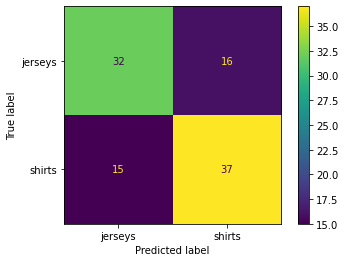

In [17]:
plot_confusion_matrix(lda_svc_pipe, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 

Classification performance pretty much the same for jerseys and shirts

### 9. Modeling: PCA + LDA + Linear SVC

Extending the assignment, I also attempt combining the reduced representations from a PCA then an LDA, and then feeding it into the SVC model. Again, here I use the best estimators for the PCA and SVC GridSearch runs as seen in sections 6 and 7.

#### Line of thinking:
-  **PCA:** Might get us components that explain a huge proportion of the variance in the data, thus reducing the image data to its essence while reducing noise. We, however, note that selected principal components could actually make it hard to separate the classes. This appears to have been the case in the model PCA + SVC model above!
- **LDA**: Working with the reduced representation from PCA, LDA could then try to maximize the separation between the two classes while projecting it down to 1 dimension, leaving the SVC's job of distinguishing the classes significantly easier.

In [18]:
#Note steps – these will be used in the creation of a pipeline
pca_lda_svc = [('PCA', PCA(n_components=5)),
               ('LDA', LinearDiscriminantAnalysis()), 
               ('clf', SVC(C=0.1, kernel='linear'))]

#Create pipeline
pca_lda_svc_pipe = Pipeline(pca_lda_svc)

#Fit the pipeline
pca_lda_svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('PCA', PCA(n_components=5)),
                ('LDA', LinearDiscriminantAnalysis()),
                ('clf', SVC(C=0.1, kernel='linear'))])

**Training set**

In [20]:
#Compute error rate for training data with best estimator
pca_lda_svc_train_acc_score = pca_lda_svc_pipe.score(X_train,y_train)
pca_lda_svc_train_error = 1 - pca_lda_svc_train_acc_score
print(f"Training set error rate (PCA + LDA + SVC): {lda_svc_train_error}")

Training set error rate (PCA + LDA + SVC): 0.05249999999999999


**Test set**

In [21]:
#Compute error rate for testdata with best estimator
pca_lda_svc_test_acc_score = pca_lda_svc_pipe.score(X_test,y_test)
pca_lda_svc_test_error = 1 - pca_lda_svc_test_acc_score
print(f"Test set error rate (PCA + LDA + SVC): {pca_lda_svc_test_error}")

Test set error rate (PCA + LDA + SVC): 0.26


This model similarly to two of the previous ones, also overfits on the training data (low training error – high test set error). We however note that it does a better job predicting the test set than all the other models above. This suggests that using a reduced representation from PCA and then LDA was actually beneficial for the model.

#### b. Confusion matrix
`Test set`

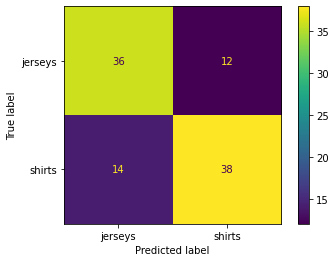

In [23]:
plot_confusion_matrix(pca_lda_svc_pipe, X_test, y_test,display_labels=['jerseys','shirts'])  
plt.show() 

This model got slightly better at distinguishing jerseys from shirts. This is evident from the increase in the top left and reduction in the top right, relative to the confusion matrices for the other models

### 10. Conclusion

Based on the results above, none of the models really perform well on the classification task. The models either overfit (in the case of the SVC, LDA + SVC, and PCA+LDA+SVC models) or underfit (in the case of the PCA + SVC model) the training data) the training data, and do not generalize well to the test data (i.e. high test error). This, however, does not mean that the models are useless! In particular, a model that overfits could still be very acceptable, depending on the task at hand. In our case, the models have an accuracy rate around 70% or so, which is not terrible.


Below I assume a task to better settle on a model. However, before doing so, I first eliminate a model (the PCA + SVC model) from consideration as it underfits and also performs the worst on both the training (28.5% error rate) and test sets (~32% error rate). Needless to say, I am highly skeptical about the model's predictive capabilities. 

#### The task at hand requiring classification

Here I assume the task at hand is to place images in categories for an e-commerce site. Hence it might be okay to show jerseys under shirts (i.e. wrongly predict jerseys as shirts) for example, and probably less so vice-versa – when people search jersey they are likely looking specifically for jerseys, unlike shirts which have a variety. Also, by definition a jersey is a shirt so this classification would not be viewed as atypical from a user's perspective.


Relating our objective to a confusion matrix, our objective would thus be to minimize the bottom left (i.e. predictions of shirts as jerseys) which will inturn increase the bottom right. In line with this, the SVC only model appears to do the best job (12 shirts classified as jerseys, compared to 14-17 for the others). In addition, it also had the lowest training error and the 2nd lowest test error rate (26%) of all the models, despite overfitting on the training data.


Another option might be the PCA+LDA+SVC model. Although it performs slightly worse on our objective, it has the advantage that it reduces the dimensions of the data, which should result in faster and more memory efficient operations, especially in comparison to the SVC model fitted on the original pixel data. Hence, it is a matter of evaluating the tradeoff between both models.


**Note:** The models were all pretty close in performance and the slightly better performance of any model might just be as a result of luck. The results might be different with an even slightly different model.